In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
def load_imdb_data():
    from keras.datasets import imdb
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data()

    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    train_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in train_data]
    test_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in test_data]

    train_df = pd.DataFrame({"review": train_reviews, "label": train_labels})
    test_df = pd.DataFrame({"review": test_reviews, "label": test_labels})

    return pd.concat([train_df, test_df]).reset_index(drop=True)


In [3]:
imdb_data = load_imdb_data()

1641221/1641221 [==============================] - 0s 0us/step


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)    
    text = text.lower()
    
    words = word_tokenize(text)    
   
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
imdb_data['review'] = imdb_data['review'].apply(preprocess_text)

In [9]:
keywords = {
      "other": [],
      "funny": [
          "comedy", "humor", "wit", "satire", "parody", "joke", "prank", "playful",
      ],
      "scary": [
          "horror", "terror", "fear", "dread", "shock", "spooky", "haunting", "eerie", "creepy",
          "frightening", "disturbing", "chilling", "macabre", "gory", "bloodcurdling", "terrifying",
          "horrifying", "gothic", "sinister", "malevolent", "ominous", "nightmarish", "supernatural",
          "paranormal", "psychological", "slasher", "zombie", "monster", "demon", "ghost", "witch",
          "vampire", "werewolf", "scream", "jump scare", "horror movie", "haunted house",
          "horror novel", "horror game", "psychological thriller"
      ],
      "dramatic": [
          "drama", "intense", "serious", "emotional", "gripping", "powerful", "poignant",
          "heart-wrenching", "heartfelt", "compelling", "profound", "deep", "meaningful",
          "thought-provoking", "insightful", "touching", "moving", "tragic", "melancholy",
          "sorrowful", "heavy", "profound", "probing", "triumphant", "uplifting", "inspiring",
          "motivational", "empathetic", "sensitive", "emotive", "soulful", "stirring", "resonant",
          "gripping", "engrossing", "character-driven", "emotionally charged", "powerful performances",
          "Oscar-worthy"
      ],
      "action": [
          "action", "adventure", "thrilling", "exciting", "fast-paced", "intense", "dangerous",
          "explosive", "suspenseful", "energetic", "daring", "heroic", "brave", "bold",
          "action-packed", "fight", "shootout", "car chase", "explosion", "stunts", "adrenaline",
          "high-octane", "martial arts", "spy", "espionage", "mission", "rescue", "heist",
          "battle", "war", "combat", "superhero", "villain", "chase scene", "firefight",
          "action hero", "fast and furious", "die hard", "james bond", "bourne identity", "avengers",
          "marvel"
      ],
      "romantic": [
          "romance", "love", "affection", "passion", "intimacy", "sentimental", "heartfelt",
          "adorable", "cute", "charming", "endearing", "sweet", "tender", "loving", "caring",
          "devoted", "committed", "romantic comedy", "chick flick", "heartwarming", "swoon-worthy",
          "chemistry", "romantic gesture", "kiss", "romantic dinner", "flowers", "gifts",
          "love story", "tragic romance", "fairy tale romance", "passionate", "emotional",
          "sensual", "sexy", "intense", "deeply romantic", "unforgettable", "timeless"
      ]
    }

In [10]:
def label_data_filtered(row):
    label_counts = {label: 0 for label in keywords.keys()}
    label_counts['other'] = 0
    review_text = row["review"].lower()

    for label, words in keywords.items():
        if any(word in review_text for word in words):
            label_counts[label] += 1

    first_genre = max(label_counts, key=label_counts.get)
    first_count = label_counts[first_genre]

    label_counts[first_genre] = 0

    second_genre = max(label_counts, key=label_counts.get)
    second_count = label_counts[second_genre]

    return first_genre

In [11]:
train_df = pd.concat([imdb_data, pd.get_dummies(imdb_data['label'], prefix='label')], axis=1)
train_df.drop(columns=['label'], inplace=True)  

In [23]:
num_classes = 6

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['review'])
sequences = tokenizer.texts_to_sequences(train_df['review'])

max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

labels = pd.get_dummies(train_df[['label_action', 'label_dramatic', 'label_funny', 'label_other', 'label_romantic','label_scary']])

train_size = int(0.8 * len(train_df))
train_data = padded_sequences[:train_size]
train_labels = labels[:train_size].values
test_data = padded_sequences[train_size:]
test_labels = labels[train_size:].values

test_data_text = train_df['review'][train_size:].tolist()

In [31]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(train_data)

# Predict the cluster labels for test data
cluster_labels = kmeans.predict(test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(test_data, cluster_labels)

In [33]:
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: -0.0117


In [34]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(test_data, cluster_labels)

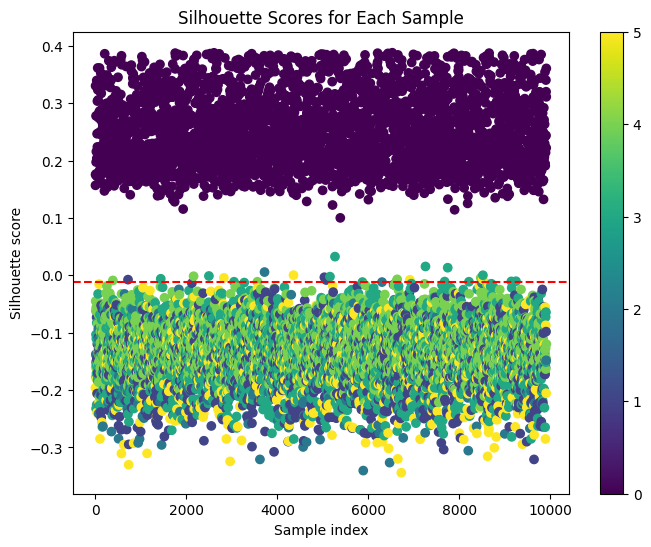

In [35]:
# Create a plot of the silhouette scores
plt.figure(figsize=(8, 6))
plt.scatter(range(len(test_data_text)), sample_silhouette_values, c=cluster_labels, cmap='viridis')
plt.axhline(y=silhouette_avg, color='red', linestyle='--')
plt.xlabel("Sample index")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores for Each Sample")
plt.colorbar()
plt.show()

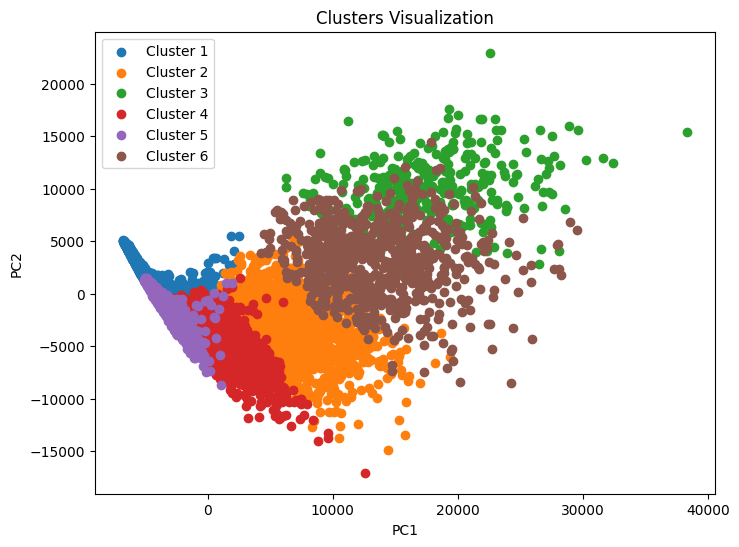

In [36]:
# Reduce dimensionality using PCA
pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(test_data)

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))
for cluster_idx in range(k):
    cluster_samples = np.where(cluster_labels == cluster_idx)[0]
    plt.scatter(x_test_pca[cluster_samples, 0], x_test_pca[cluster_samples, 1], label=f"Cluster {cluster_idx + 1}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters Visualization")
plt.legend()
plt.show()